Step 0. Import Python libraries and main dataset

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [34]:
from sklearn.model_selection import train_test_split

In [3]:
DSNY = pd.read_csv('311-DSNY-20151017.csv')
print(DSNY.shape,DSNY['Unique Key'].nunique())

(576487, 41) 576487


In [4]:
DSNY_df = DSNY.copy()
DSNY_df.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                      float64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                          float64
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

Step 1. Hand-picked categotical variables and valuate them

In [5]:
dict_df = pd.read_csv('311_SR_Data_Dictionary_2018.csv')
ca_list = list(dict_df['Column Name'])
print(len(ca_list))
rm_list = [0,1,2,8,9,12,13,14,15,16,17,18,19,24,26,27,29,30,31]
for i in sorted(rm_list, reverse = True):
    del ca_list[i]
print(len(ca_list))
ca_list = np.array(ca_list)
ca_list = np.where(ca_list == 'Open_Data_Channel_Type', 'Open Data Channel Type', ca_list)
ca_list

41
22


array(['Agency', 'Agency Name', 'Complaint Type', 'Descriptor', 'Status',
       'Resolution Description', 'Location Type', 'City', 'Landmark',
       'Facility Type', 'Community Board', 'Borough',
       'Open Data Channel Type', 'Park Facility Name', 'Park Borough',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment'], dtype='<U24')

In [6]:
list(DSNY_df.shape)[0]

576487

In [7]:
for i in ca_list:
    print(i,DSNY_df[i].isnull().sum()/list(DSNY_df.shape)[0])
    print(DSNY_df[i].value_counts())
    print('***')

Agency 0.0
DSNY    576487
Name: Agency, dtype: int64
***
Agency Name 0.0
Department of Sanitation                                  190962
BCC - Brooklyn South                                       41783
A - Brooklyn                                               37179
A - Queens                                                 33271
BCC - Brooklyn North                                       32553
BCC - Staten Island                                        29379
BCC - Queens East                                          28503
BCC - Queens West                                          17385
A - Manhattan                                              16591
A - Bronx                                                  13511
BCC - Bronx                                                11647
Queens East 12                                             10359
A - Staten Island                                           9532
Queens East 10                                              8293
A - Canine Task F

Observations:
1. Data quality is good - no duplicates, misspelling, and little missing in key infomation
2. Some of the features are completely missing, although they are less important

Step 2. Check numeric & time variables

In [8]:
print(DSNY_df['Created Date'].isnull().sum())
print(DSNY_df['Closed Date'].isnull().sum())
print(DSNY_df['Due Date'].isnull().sum())

0
6245
533927


In [9]:
DSNY_df['Closed Date'] = DSNY_df['Closed Date'].fillna('12/31/2022')
DSNY_df['Due Date'] = DSNY_df['Due Date'].fillna('12/31/2022')

In [10]:
print(DSNY_df['Created Date'].isnull().sum())
print(DSNY_df['Closed Date'].isnull().sum())
print(DSNY_df['Due Date'].isnull().sum())

0
0
0


In [11]:
DSNY_df['Created_Date'] = DSNY_df['Created Date'].str[:10]
DSNY_df['Closed_Date'] = DSNY_df['Closed Date'].str[:10]
DSNY_df['Due_Date'] = DSNY_df['Due Date'].str[:10]
DSNY_df['Created_Year'] = DSNY_df['Created Date'].str[6:10]
DSNY_df['Closed_Year'] = DSNY_df['Closed Date'].str[6:10]
DSNY_df['Due_Year'] = DSNY_df['Due Date'].str[6:10]

In [12]:
print(DSNY_df['Created_Date'].min(),DSNY_df['Created_Date'].max())
print(DSNY_df['Closed_Date'].min(),DSNY_df['Closed_Date'].max())
print(DSNY_df['Due_Date'].min(),DSNY_df['Due_Date'].max())
print(DSNY_df['Created_Year'].min(),DSNY_df['Created_Year'].max())
print(DSNY_df['Closed_Year'].min(),DSNY_df['Closed_Year'].max())
print(DSNY_df['Due_Year'].min(),DSNY_df['Due_Year'].max())

01/01/2015 12/31/2017
01/01/1900 12/31/2022
01/02/2017 12/31/2022
2015 2017
1900 3027
2015 2022


In [13]:
DSNY_df[DSNY_df['Closed_Date'].str.contains('3027')]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,Created_Date,Closed_Date,Due_Date,Created_Year,Closed_Year,Due_Year
375058,35297016,01/21/2017 07:58:02 PM,03/30/3027 12:00:00 AM,DSNY,Department of Sanitation,Graffiti,Graffiti,NaN,10012.0,65 MACDOUGAL STREET,...,NaN,40.728449,-74.001811,"(40.72844854487639, -74.00181121179423)",01/21/2017,03/30/3027,03/09/2017,2017,3027,2017


In [14]:
DSNY_df[DSNY_df['Closed_Date'].str.contains('1900')]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,Created_Date,Closed_Date,Due_Date,Created_Year,Closed_Year,Due_Year
179951,31124352,07/21/2015 03:34:00 PM,01/01/1900 12:00:00 AM,DSNY,BCC - Brooklyn South,Litter Basket / Request,10 Litter Basket / Request,Sidewalk,11235.0,103 ORIENTAL BOULEVARD,...,NaN,40.576919,-73.952609,"(40.5769186244049, -73.95260855002165)",07/21/2015,01/01/1900,12/31/2022,2015,1900,2022
179954,31124355,07/21/2015 02:58:00 PM,01/01/1900 12:00:00 AM,DSNY,BCC - Queens West,Missed Collection (All Materials),1RO Missed Recycling Organics,NaN,11379.0,62-53 84 STREET,...,NaN,40.724137,-73.871856,"(40.72413660117931, -73.87185599156355)",07/21/2015,01/01/1900,12/31/2022,2015,1900,2022


In [15]:
DSNY_df_clean = DSNY_df[DSNY_df['Closed_Year'].astype(int)<2022]
DSNY_df_clean = DSNY_df_clean[DSNY_df_clean['Closed_Year'].astype(int)>=2015]
DSNY_df_clean.shape

(570221, 47)

In [16]:
DSNY_df_clean['Created_DT'] = pd.to_datetime(DSNY_df_clean['Created_Date'])
DSNY_df_clean['Closed_DT'] = pd.to_datetime(DSNY_df_clean['Closed_Date'])
DSNY_df_clean['Due_DT'] = pd.to_datetime(DSNY_df_clean['Due_Date'])

DSNY_df_clean['Created_Year_Month'] = DSNY_df_clean['Created_Date'].str[6:10]+'-'+DSNY_df_clean['Created_Date'].str[:2]
DSNY_df_clean['Closed_Year_Month'] = DSNY_df_clean['Closed_Date'].str[6:10] +'-'+ DSNY_df_clean['Closed_Date'].str[:2]
DSNY_df_clean['Due_Year_Month'] = DSNY_df_clean['Due_Date'].str[6:10] +'-'+ DSNY_df_clean['Due_Date'].str[:2]
DSNY_df_clean.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Due_Date,Created_Year,Closed_Year,Due_Year,Created_DT,Closed_DT,Due_DT,Created_Year_Month,Closed_Year_Month,Due_Year_Month
1,29655441,01/07/2015 08:17:00 AM,01/07/2015 12:00:00 PM,DSNY,BCC - Queens East,Snow,15S Re-Plow/Spread/Ice-Snow Cond.,Street,NaN,NaN,...,12/31/2022,2015,2015,2022,2015-01-07,2015-01-07,2022-12-31,2015-01,2015-01,2022-12
2,29750581,01/19/2015 05:00:00 PM,01/21/2015 12:00:00 PM,DSNY,BCC - Queens West,Litter Basket / Request,10 Litter Basket / Request,Sidewalk,NaN,NaN,...,12/31/2022,2015,2015,2022,2015-01-19,2015-01-21,2022-12-31,2015-01,2015-01,2022-12
3,29767423,01/22/2015 09:21:00 AM,01/31/2015 12:00:00 PM,DSNY,A - Canine Task Force Citywide,Dirty Conditions,E8 Canine Violation,Sidewalk,NaN,QUEENS BOULEVARD,...,12/31/2022,2015,2015,2022,2015-01-22,2015-01-31,2022-12-31,2015-01,2015-01,2022-12
4,29618799,01/02/2015 06:11:00 AM,01/05/2015 12:00:00 PM,DSNY,Bronx 10,Sanitation Condition,12 Dead Animals,Sidewalk,NaN,HUTCHISON RIVER PKW,...,12/31/2022,2015,2015,2022,2015-01-02,2015-01-05,2022-12-31,2015-01,2015-01,2022-12
5,29618633,01/02/2015 09:57:00 AM,01/05/2015 12:00:00 PM,DSNY,Brooklyn North 03,Sweeping/Missed,3A Sweeping/Missed,Sidewalk,NaN,NaN,...,12/31/2022,2015,2015,2022,2015-01-02,2015-01-05,2022-12-31,2015-01,2015-01,2022-12


In [91]:
# DSNY_df_clean['Created_Year_Month'] = DSNY_df_clean['Created_DT'].dt.year.astype(str) + '-' + DSNY_df_clean['Created_DT'].dt.month.astype(str)
# DSNY_df_clean['Closed_Year_Month'] = DSNY_df_clean['Closed_DT'].dt.year.astype(str) + '-' + DSNY_df_clean['Closed_DT'].dt.month.astype(str)
# DSNY_df_clean['Due_Year_Month'] = DSNY_df_clean['Due_DT'].dt.year.astype(str) + '-' + DSNY_df_clean['Due_DT'].dt.month.astype(str)
# DSNY_df_clean.head()

[Text(0.5, 0, 'SR Create Date'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Check SR Create Date')]

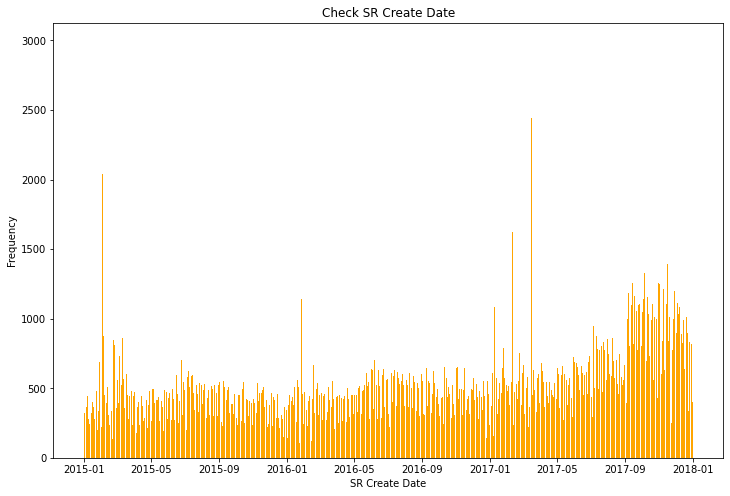

In [17]:
Created_DT_Bar = pd.DataFrame(DSNY_df_clean['Created_DT'].value_counts()).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(Created_DT_Bar['index'],
       Created_DT_Bar['Created_DT'],
       color='orange')

# Set title and labels for axes
ax.set(xlabel="SR Create Date",
       ylabel="Frequency",
       title="Check SR Create Date")

[Text(0.5, 0, 'SR Close Date'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Check SR Close Date')]

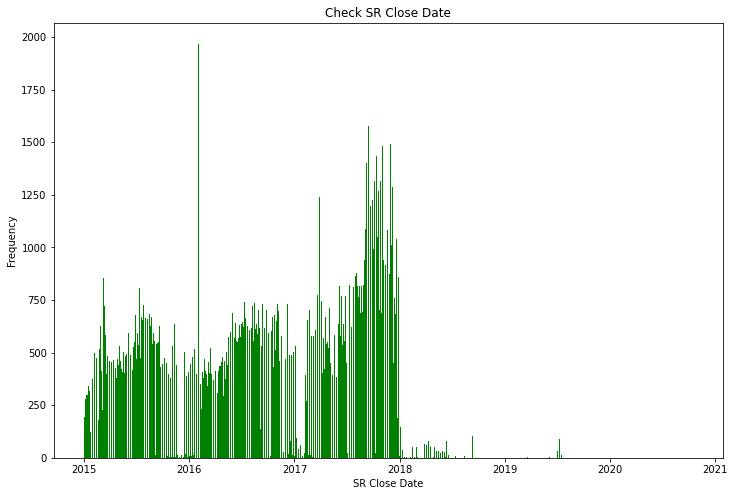

In [18]:
Closed_DT_Bar = pd.DataFrame(DSNY_df_clean['Closed_DT'].value_counts()).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(Closed_DT_Bar['index'],
       Closed_DT_Bar['Closed_DT'],
       color='green')

# Set title and labels for axes
ax.set(xlabel="SR Close Date",
       ylabel="Frequency",
       title="Check SR Close Date")

[Text(0.5, 0, 'SR Close Date'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Check SR Close Date - Closer Look')]

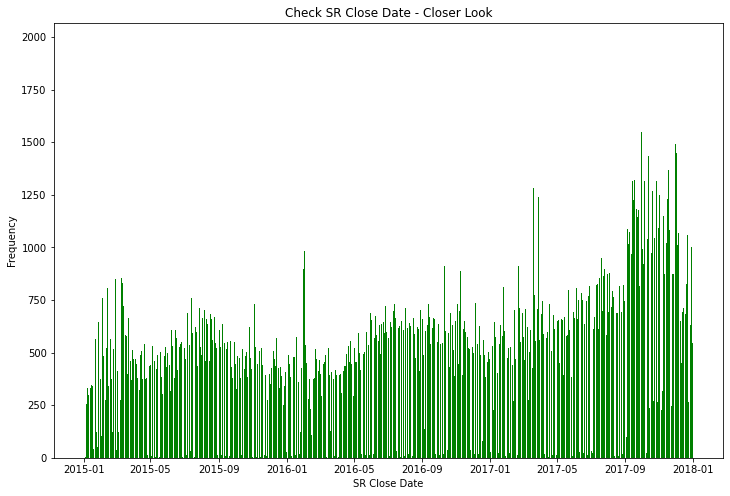

In [19]:
Closed_DT_Bar2 =  Closed_DT_Bar[Closed_DT_Bar['index']<'2018-01-01']
fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(Closed_DT_Bar2['index'],
       Closed_DT_Bar2['Closed_DT'],
       color='green')

# Set title and labels for axes
ax.set(xlabel="SR Close Date",
       ylabel="Frequency",
       title="Check SR Close Date - Closer Look")

In [20]:
DSNY_df_clean['Processing_Days'] = (DSNY_df_clean['Closed_DT'] - DSNY_df_clean['Created_DT']).dt.days
print(DSNY_df_clean['Processing_Days'].min(),DSNY_df_clean['Processing_Days'].max(),DSNY_df_clean['Processing_Days'].isnull().sum())

-321 1547 0


[Text(0.5, 0, 'Processing Days'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Processing Days')]

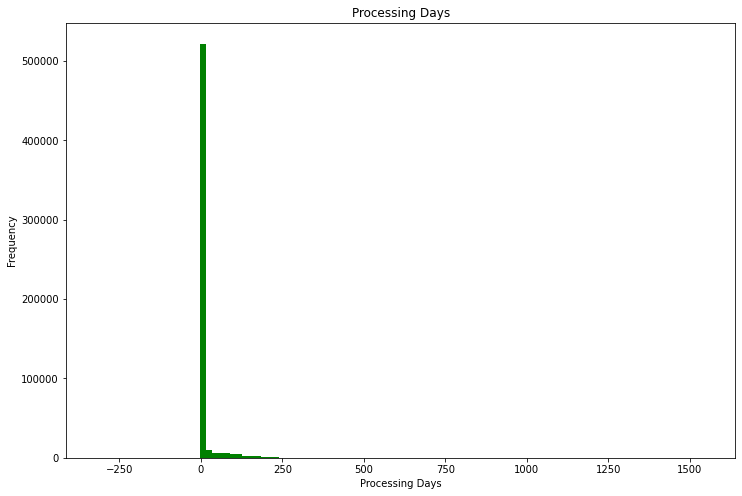

In [21]:
# n, bins, patches = plt.hist(DSNY_df_clean['Processing_Days'], 50)
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(DSNY_df_clean['Processing_Days'],100,color='green')

# Set title and labels for axes
ax.set(xlabel="Processing Days",
       ylabel="Frequency",
       title="Processing Days")

566801 0.9940023254141815


[Text(0.5, 0, 'Processing Days'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Processing Days - Closer Look')]

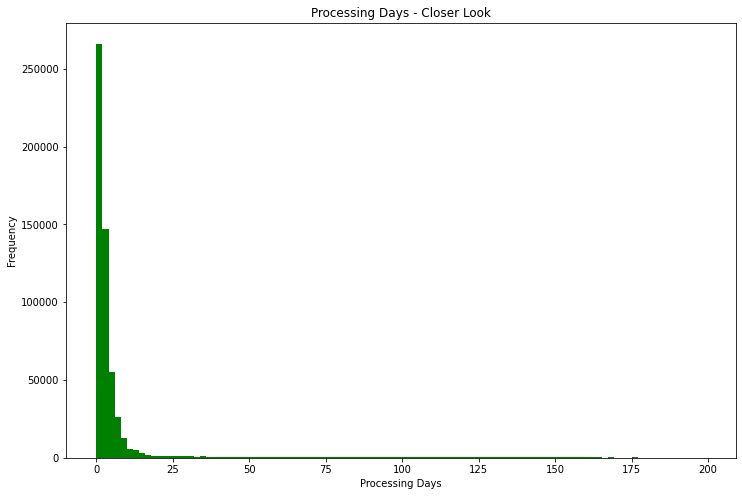

In [22]:
PD_filtered = list(filter(lambda days: (days >= 0) & (days<200), DSNY_df_clean['Processing_Days']))
print(len(PD_filtered),len(PD_filtered)/len(DSNY_df_clean['Processing_Days']))

fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(PD_filtered,100,color='green')

# Set title and labels for axes
ax.set(xlabel="Processing Days",
       ylabel="Frequency",
       title="Processing Days - Closer Look")

552377 0.9687068697925892


[Text(0.5, 0, 'Processing Days'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Processing Days - Even Closer Look')]

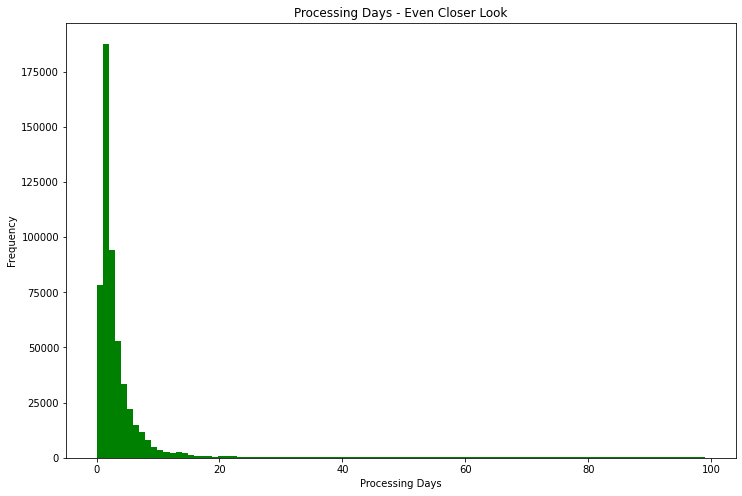

In [23]:
PD_filtered = list(filter(lambda days: (days >= 0) & (days<100), DSNY_df_clean['Processing_Days']))
print(len(PD_filtered),len(PD_filtered)/len(DSNY_df_clean['Processing_Days']))

fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(PD_filtered,100,color='green')

# Set title and labels for axes
ax.set(xlabel="Processing Days",
       ylabel="Frequency",
       title="Processing Days - Even Closer Look")

[Text(0.5, 1.0, 'Latitude*Longitude')]

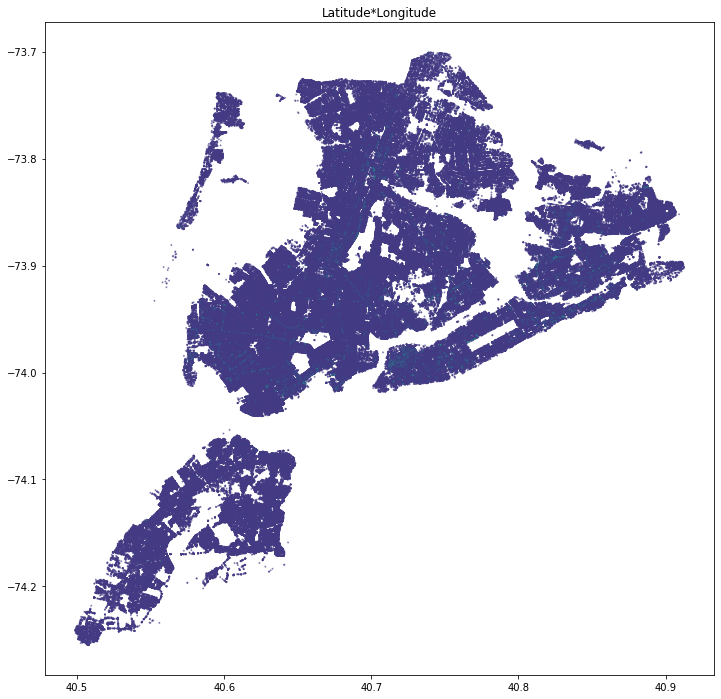

In [24]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(DSNY_df_clean['Latitude'], DSNY_df_clean['Longitude'], s=1,c=(DSNY_df_clean['Processing_Days'])/10, alpha=0.5)

ax.set(title="Latitude*Longitude")

[Text(0.5, 1.0, 'X Coordinate * Y Coordinate')]

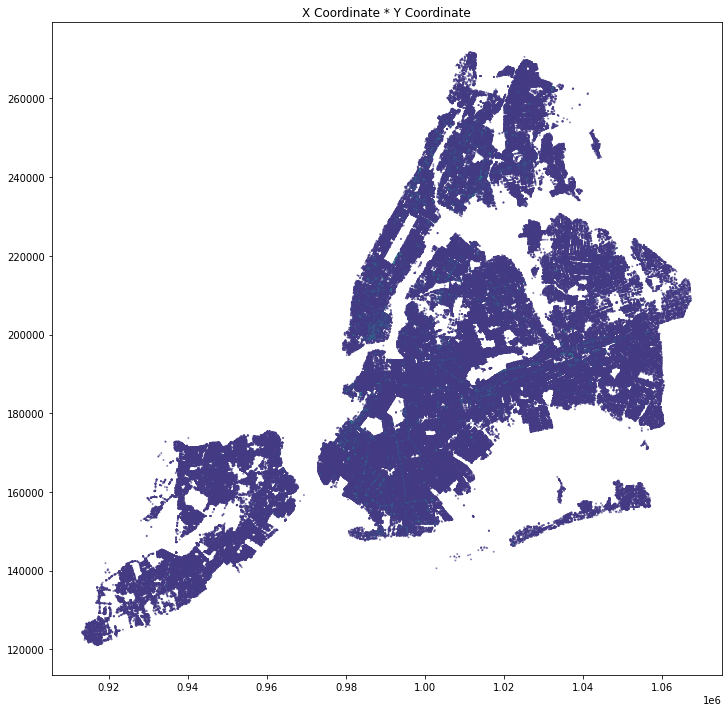

In [25]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(DSNY_df_clean['X Coordinate (State Plane)'], DSNY_df_clean['Y Coordinate (State Plane)'], s=1,c=DSNY_df_clean['Processing_Days']/10, alpha=0.5)

ax.set(title="X Coordinate * Y Coordinate")

In [26]:
DSNY_df_clean['Processing_Days_Flag'] = np.where(DSNY_df_clean['Processing_Days']>7,'red','green')
DSNY_df_clean['Processing_Days_Flag'].value_counts()

green    495245
red       74976
Name: Processing_Days_Flag, dtype: int64

[Text(0.5, 1.0, 'X Coordinate * Y Coordinate - Processing Time Comparison')]

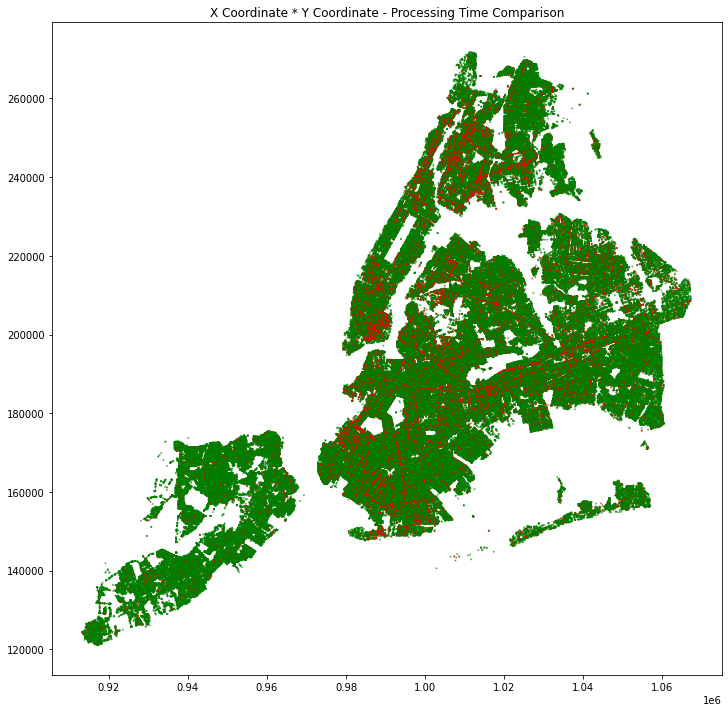

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(DSNY_df_clean['X Coordinate (State Plane)'], DSNY_df_clean['Y Coordinate (State Plane)'], s=1,c=DSNY_df_clean['Processing_Days_Flag'], alpha=0.5)

ax.set(title="X Coordinate * Y Coordinate - Processing Time Comparison")

Observations
1. Some cleanse is needed for close date
2. Majority of processing time is legit and can be used for modeling
3. Geo location seems asscocited with processing time 

Step 3. Predict processing time

Hand-picked features for baseline model (easy to interpret): Agency Name, Complaint Type, Location Type, City, Borough, Community Board, Open Data Channel Type

Step 3.1 Model data prep

In [28]:
DSNY_df_model = DSNY_df_clean[['Unique Key','Agency Name','Complaint Type','Location Type','City','Borough','Community Board','Open Data Channel Type','Processing_Days']]
DSNY_df_model = DSNY_df_model[(DSNY_df_model['Processing_Days']>=0) & (DSNY_df_model['Processing_Days']<=100)]
print(DSNY_df_model.shape,DSNY_df_model['Processing_Days'].min(),DSNY_df_model['Processing_Days'].max(),list(DSNY_df_model.shape)[0]/list(DSNY_df.shape)[0])

(552634, 9) 0 100 0.958623524901689


In [29]:
DSNY_df_model = pd.get_dummies(DSNY_df_model)
DSNY_df_model.head()

,Unique Key,Processing_Days,Agency Name_A - Bronx,Agency Name_A - Brooklyn,Agency Name_A - Canine Task Force Citywide,Agency Name_A - Illegal Posting Manhattan and Bronx,"Agency Name_A - Illegal Posting Staten Island, Queens and Brooklyn",Agency Name_A - Manhattan,Agency Name_A - Queens,Agency Name_A - Staten Island,...,Community Board_Unspecified BRONX,Community Board_Unspecified BROOKLYN,Community Board_Unspecified MANHATTAN,Community Board_Unspecified QUEENS,Community Board_Unspecified STATEN ISLAND,Open Data Channel Type_MOBILE,Open Data Channel Type_ONLINE,Open Data Channel Type_OTHER,Open Data Channel Type_PHONE,Open Data Channel Type_UNKNOWN
1,29655441,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,29750581,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,29767423,9,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,29618799,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,29618633,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
labels = np.array(DSNY_df_model['Processing_Days'])
DSNY_df_model_feature = DSNY_df_model.drop(['Processing_Days','Unique Key'], axis = 1)
feature_list = list(DSNY_df_model_feature.columns)
DSNY_df_model_feature = np.array(DSNY_df_model_feature)

In [35]:
train_features, test_features, train_labels, test_labels = train_test_split(DSNY_df_model_feature, labels, test_size = 0.30, random_state = 1017)

In [36]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (386843, 207)
Training Labels Shape: (386843,)
Testing Features Shape: (165791, 207)
Testing Labels Shape: (165791,)


Step 3.2 Random forest regression

In [37]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1017)
rf.fit(train_features, train_labels)

In [39]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Random Forest Mean Absolute Error:', round(np.mean(errors), 2))

Random Forest Mean Absolute Error: 2.72


Step 3.3 Gradient boosting regression

In [ ]:
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}
gbr = GradientBoostingRegressor(**params)
gbr.fit(train_features, train_labels)
predictions = gbr.predict(test_features)
errors = abs(predictions - test_labels)
print('DT Mean Absolute Error:', round(np.mean(errors), 2))

Step 3.4 Decision tree regression

In [ ]:
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(train_features, train_labels)
predictions = dtr.predict(test_features)
errors = abs(predictions - test_labels)
print('DT Mean Absolute Error:', round(np.mean(errors), 2))